# Attack and Defense Analysis

In [1]:
import torchattacks as ta
import timm
import torch
from birdclassifier import BirdDataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance

/home/grads/hassledw/miniconda3/envs/genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Attack Example on Bird Dataset

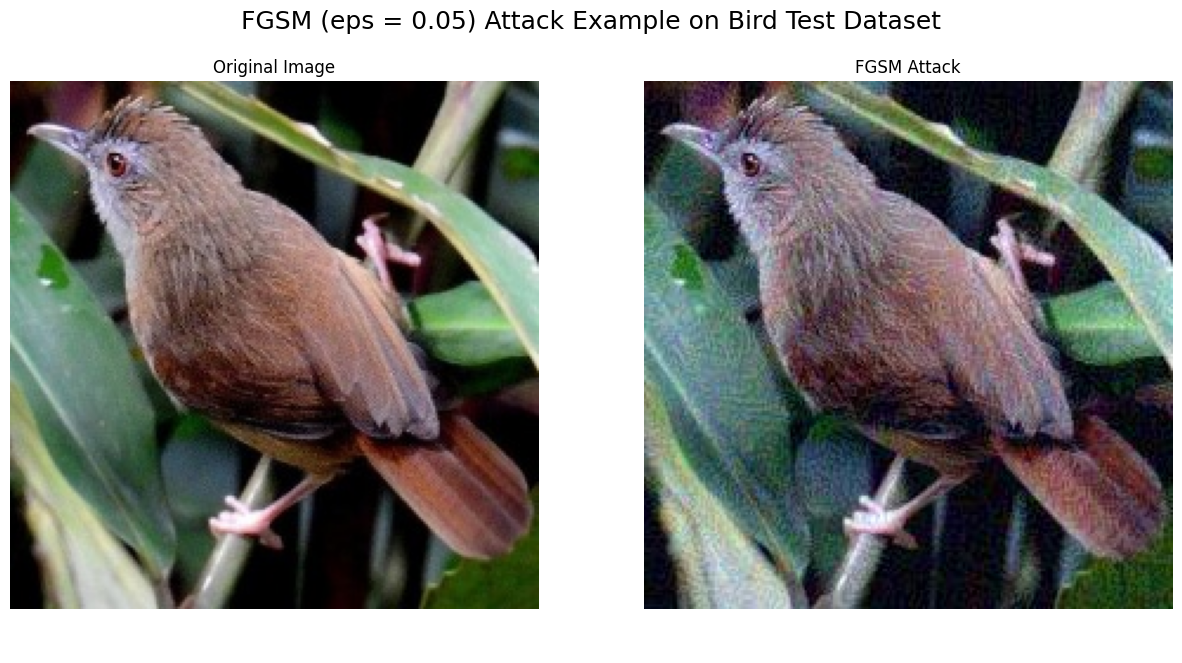

In [2]:
plt.figure(figsize=(15, 8))  # Adjust the (width, height) as needed
plt.axis('off')
plt.title("FGSM (eps = 0.05) Attack Example on Bird Test Dataset", fontsize=18)

filenames = [f"./bird-data/test/ABBOTTS BABBLER/1.jpg", f"./bird-data/FGSM05-test/ABBOTTS BABBLER/1.jpg"]
titles = ["Original Image", "FGSM Attack"]
# labels = [test_label, test_label, attack_label, defend_label]
n_examples = len(filenames)

for i, filename in enumerate(filenames):
    plt.subplot(1, n_examples, i + 1)
    plt.axis('off')
    plt.title(f"{titles[i]}")
    img = mpimg.imread(f'{filename}')
    imgplot = plt.imshow(img)
    # plt.text(0.5, -0.10, f"Label {labels[i]}", ha='center', transform=plt.gca().transAxes)
plt.show()

## Plot Functions

In [165]:
def plot_denoising_defense(df, attack_folder, title):
    plt.figure(figsize=(15, 6))  # Adjust the (width, height) as needed
    plt.axis('off')
    plt.title(title, fontsize=18)
    random_i = np.random.randint(0, df.shape[0])
    random_example = df.iloc[random_i]

    defense_column = [column for column in df.columns if "defense" in column][0]

    test_file_path = f"./bird-data/test/{random_example['image']}"
    attack_file_path = f"./bird-data/{attack_folder}/{random_example['image']}"
    defense_file_path = f"./bird-data/{attack_folder}-def-{defense_column.split('_')[-1]}/{random_example['image']}"

    test_label = random_example["image"].split("/")[0]
    attack_label = random_example["attack_label"]
    defense_label = random_example[f"{defense_column}"]

    filenames = [test_file_path, attack_file_path, defense_file_path]
    titles = ["Original Image", "FGSM Attack", f"Denoised ({defense_column.split('_')[-1]})"]
    labels = [test_label, attack_label, defense_label]
    n_examples = len(filenames)

    for i, filename in enumerate(filenames):
        plt.subplot(1, n_examples, i + 1)
        plt.axis('off')
        plt.title(f"{titles[i]}")
        img = mpimg.imread(f'{filename}')
        imgplot = plt.imshow(img)
        plt.text(0.5, -0.10, f"{labels[i]}", ha='center', transform=plt.gca().transAxes)
        
    plt.show()

def plot_denoising_defense_with_input_transform(df, attack_folder, input_transform_folder, title):
    input_transform_filename = None
    attack_name = attack_folder.split("-")[0]
    if input_transform_folder == "nl-means":
        input_transform_filename = f"{attack_name}-nlmeans-test"
    else:
        input_transform_filename = f"{attack_name}-wavelet-test"

    plt.figure(figsize=(15, 6))  # Adjust the (width, height) as needed
    plt.axis('off')
    plt.title(title, fontsize=18)
    random_i = np.random.randint(0, df.shape[0])
    random_example = df.iloc[random_i]

    defense_column = [column for column in df.columns if "defense" in column][0]

    test_file_path = f"./bird-data/test/{random_example['image']}"
    attack_file_path = f"./bird-data/{attack_folder}/{random_example['image']}"
    input_transform_path = f"./bird-data/{input_transform_folder}/{input_transform_filename}/{random_example['image']}"
    defense_file_path = f"./bird-data/{input_transform_folder}/{input_transform_filename}-def-{defense_column.split('_')[-1]}/{random_example['image']}"

    test_label = random_example["image"].split("/")[0]
    attack_label = random_example["attack_label"]
    input_transform_label = "None"
    defense_label = random_example[f"{defense_column}"]

    filenames = [test_file_path, attack_file_path, input_transform_path, defense_file_path]
    titles = ["Original Image", "FGSM Attack", f"{input_transform_folder}".capitalize(), f"Denoised ({defense_column.split('_')[-1]})"]
    labels = [test_label, attack_label, input_transform_label, defense_label]
    n_examples = len(filenames)

    for i, filename in enumerate(filenames):
        plt.subplot(1, n_examples, i + 1)
        plt.axis('off')
        plt.title(f"{titles[i]}")
        img = mpimg.imread(f'{filename}')
        imgplot = plt.imshow(img)
        plt.text(0.5, -0.10, f"{labels[i]}", ha='center', transform=plt.gca().transAxes)
        
    plt.show()

def plot_each_timestep(df, attack_folder, input_transform_folder, title):
    input_transform_filename = None
    attack_name = attack_folder.split("-")[0]
    if input_transform_folder == "nl-means":
        input_transform_filename = f"{attack_name}-nlmeans-test"
    else:
        input_transform_filename = f"{attack_name}-wavelet-test"

    plt.figure(figsize=(15, 6))  # Adjust the (width, height) as needed
    plt.axis('off')
    plt.title(title, fontsize=18)
    random_i = np.random.randint(0, df.shape[0])
    random_example = df.iloc[random_i]

    filenames = []
    titles = []
    labels = []

    defense_column = [column for column in df.columns if "defense" in column]

    for d_column in defense_column:
        defense_file_path = f"./bird-data/{input_transform_folder}/{input_transform_filename}-def-{d_column.split('_')[-1]}/{random_example['image']}"
        defense_label = random_example[f"{d_column}"]
        filenames.append(defense_file_path)
        titles.append(f"Denoised ({d_column.split('_')[-1]})")
        labels.append(defense_label)
        
        n_examples = len(filenames)
    for i, filename in enumerate(filenames):
        plt.subplot(1, n_examples, i + 1)
        plt.axis('off')
        plt.title(f"{titles[i]}")
        img = mpimg.imread(f'{filename}')
        imgplot = plt.imshow(img)
        plt.text(0.5, -0.10, f"{labels[i]}", ha='center', transform=plt.gca().transAxes)
        
    plt.show()    

def plot_clean_from_adv(df, attack_folder, title):
    plt.figure(figsize=(15, 6))  # Adjust the (width, height) as needed
    plt.axis('off')
    plt.title(title, fontsize=18)
    random_i = np.random.randint(0, df.shape[0])
    random_example = df.iloc[random_i]

    defense_column = [column for column in df.columns if "defense" in column][0]

    test_file_path = f"./bird-data/test/{random_example['image']}"
    attack_file_path = f"./bird-data/{attack_folder}/{random_example['image']}"
    defense_file_path = f"./bird-data/{attack_folder}-def-{defense_column.split('_')[-1]}/{random_example['image']}"

    test_label = random_example["image"].split("/")[0]
    attack_label = random_example["attack_label"]
    defense_label = random_example[f"{defense_column}"]

    filenames = [test_file_path, attack_file_path, defense_file_path]
    titles = ["Original Image", "FGSM Attack", f"Generated Image ({defense_column.split('_')[-1]})"]
    labels = [test_label, attack_label, defense_label]
    n_examples = len(filenames)

    for i, filename in enumerate(filenames):
        plt.subplot(1, n_examples, i + 1)
        plt.axis('off')
        plt.title(f"{titles[i]}")
        img = mpimg.imread(f'{filename}')
        imgplot = plt.imshow(img)
        plt.text(0.5, -0.10, f"{labels[i]}", ha='center', transform=plt.gca().transAxes)
        
    plt.show() 

## Defense Evaluation Class

In [195]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class DefenseEval:
    def __init__(self, title, df):
        self.title = title
        self.attack_name = self.title.split(" ")[0]
        self.df = df
        self.N = self.df.shape[0]
        self.succ_attacks_df = self.df[self.df['model_test_label'] != self.df['attack_label']]
        self.succ_attacks_percentage = self.succ_attacks_df.shape[0] / self.N
        self.N_succ_attack = self.succ_attacks_df.shape[0]
        self.succ_denoise = [] # a list of all succ_denoised datasets.
        self.attack_eq_denoise = []
        self.succ_defense_df = pd.DataFrame() # a table resulting in defense evaluation.
        self.defense_columns = [col for col in self.df.columns if "defense" in col] # defense column names

    def evaluate_def(self):
        # loop through the defense tests and make metrics
        for defense_col in self.defense_columns:
            A_eq_C = self.df[self.df[defense_col] == self.df['model_test_label']]
            A_neq_B = self.succ_attacks_df
            
            A_neq_B_and_A_eq_C = A_neq_B.merge(A_eq_C, how='inner', on=['image', 'attack_label', defense_col])
            A_neq_B_and_A_eq_C = A_neq_B_and_A_eq_C[['image', 'attack_label', defense_col]]
            
            self.succ_denoise.append(A_neq_B_and_A_eq_C)

        # add the succ. denoising specs to succ_defense dataframe
        succ_denoise_list = []
        
        for succ_denoise_df in self.succ_denoise:
            if "defense" not in self.succ_defense_df.columns:
                self.succ_defense_df["defense"] = self.defense_columns

            succ_denoise_list.append(f"{(succ_denoise_df.shape[0] / self.N_succ_attack) * 100:.2f}")

        self.succ_defense_df["denoise succ."] = succ_denoise_list

        return self.succ_defense_df
    
    def calculate_fid(self, root="./bird-data"):
        '''
        Calculates the FID on all defense sets. Since the intermediate results are
        in batches, I take the average score of it.
        '''

        # pair filepaths to defense names
        entries = os.listdir(root)
        folder_names = np.array([entry for entry in entries if os.path.isdir(os.path.join(root, entry))])
        indices = np.where(np.char.find(folder_names, self.attack_name) != -1)
        folder_names = folder_names[indices]
        defense_and_filepath_dict = {}

        for defense_name in self.defense_columns:
            t_val_def = defense_name.split("_")[-1]
            for folder_name in folder_names:
                t_val = folder_name.split("-")[-1]
                if t_val == t_val_def:
                    defense_and_filepath_dict[defense_name] = folder_name

        print(defense_and_filepath_dict)
        fid_avg_defenses = []
        
        for defense_name in defense_and_filepath_dict:
            ds_def = BirdDataset(root, defense_and_filepath_dict[defense_name])
            dl_def = DataLoader(ds_def, batch_size=15, shuffle=False, num_workers=4)
            ds_true = BirdDataset("./bird-data", "test")
            dl_true = DataLoader(ds_true, batch_size=15, shuffle=False, num_workers=4)

            fid_avg_defense = [] 
            for i, batch in enumerate(zip(dl_true, dl_def)):
                true_images, label_ids_true = batch[0]
                def_images, label_ids_def = batch[1]
        
                fid = FrechetInceptionDistance(feature=64)
                fid.update(torch.tensor(true_images, dtype=torch.uint8), real=True)
                fid.update(torch.tensor(def_images, dtype=torch.uint8), real=False)
                fid_avg_defense.append(fid.compute().item())

            print(f"Finished FID calculation for {defense_name}")    
            fid_avg_defenses.append(np.mean(fid_avg_defense))
        
        return fid_avg_defenses
    
    def store_fid(self, fid_avg_defenses):
        self.succ_defense_df["FID"] = fid_avg_defenses

    def print_metrics(self):
        print(self.title)
        print(f"Successfully Attacked: {self.succ_attacks_percentage * 100 : .2f}%")
        print(f"Successfully Denoised: \n", self.succ_defense_df)

## DDPM Defense Evaluation on FGSM eps=0.05 Attack

DDPM is setup to just do reverse process for `t` timesteps. There is no noise added to forward.

### Defense-DDPM on no Input Transformations

In [12]:
fgsm05_def_nofwd_df = pd.read_csv("./evaluation_csvs/FGSM05-test-defense-eval.csv")
fgsm05_def_nofwd_eval = DefenseEval("FGSM05 Defense (backward_t)", fgsm05_def_nofwd_df)

fgsm05_def_nofwd_eval.evaluate_def()
fgsm05_def_nofwd_eval.print_metrics()

# fid_avg_defenses = fgsm05_def_nofwd_eval.calculate_fid()
# fgsm05_def_nofwd_eval.store_fid(fid_avg_defenses)
# fgsm05_def_nofwd_eval.print_metrics()

# fgsm05_def_nofwd_eval.succ_defense_df.to_csv("./evaluation_csvs/FGSM05-defense-no-input-transform-results.csv")


FGSM05 Defense (backward_t)
Successfully Attacked:  74.86%
Successfully Denoised: 
                defense denoise succ.
0    defense_label_t=1         23.66
1    defense_label_t=2         23.92
2    defense_label_t=5         28.30
3   defense_label_t=10         35.22
4   defense_label_t=20         42.19
5   defense_label_t=30         41.53
6   defense_label_t=40         41.48
7  defense_label_t=100         35.06


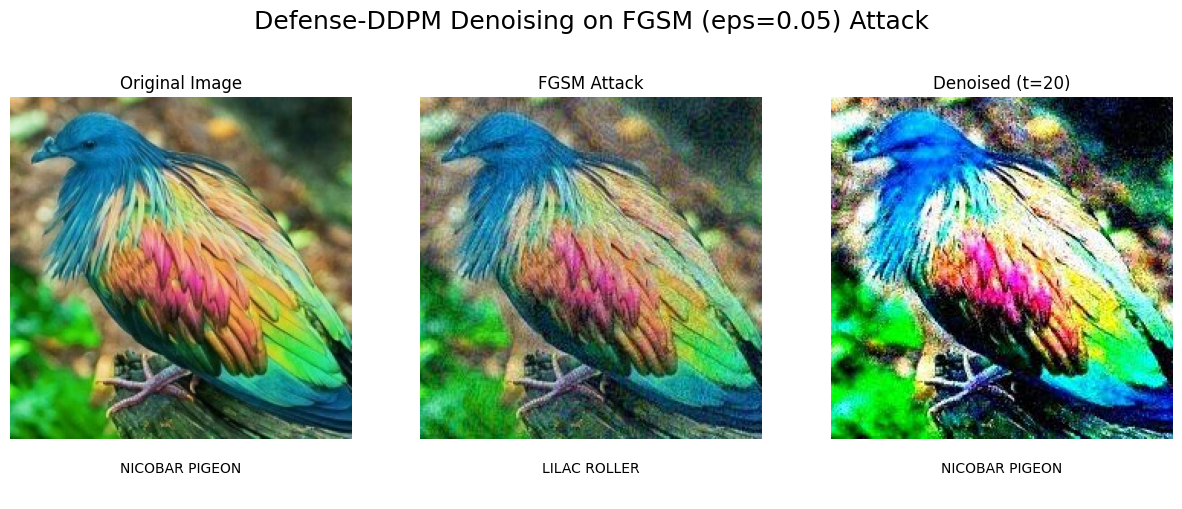

In [17]:
plot_denoising_defense(fgsm05_def_nofwd_eval.succ_denoise[4], attack_folder="FGSM05-test", title="Defense-DDPM Denoising on FGSM (eps=0.05) Attack")

### Defense-DDPM with Wavelet Transform Denoised Input

In [34]:
fgsm05_def_nofwd_wavelet_df = pd.read_csv("./evaluation_csvs/FGSM05-test-wavelet-defense-eval.csv")
fgsm05_def_nofwd_wavelet_eval = DefenseEval("FGSM05 Defense w/ Wavelet Pre-processing (backward_t)", fgsm05_def_nofwd_wavelet_df)

fgsm05_def_nofwd_wavelet_eval.evaluate_def()
fgsm05_def_nofwd_wavelet_eval.print_metrics()

# fid_avg_defenses_wavelet = fgsm05_def_nofwd_wavelet_eval.calculate_fid(root="./bird-data/wavelet")
# fgsm05_def_nofwd_wavelet_eval.store_fid(fid_avg_defenses_wavelet)
# fgsm05_def_nofwd_wavelet_eval.print_metrics()

# fgsm05_def_nofwd_wavelet_eval.succ_defense_df.to_csv("./evaluation_csvs/FGSM05-defense-wavelet-transform-results.csv")

FGSM05 Defense w/ Wavelet Pre-processing (backward_t)
Successfully Attacked:  74.86%
Successfully Denoised: 
                defense denoise succ.
0    defense_label_t=1         27.94
1    defense_label_t=2         28.91
2    defense_label_t=5         34.66
3   defense_label_t=10         44.02
4   defense_label_t=20         46.97
5   defense_label_t=30         48.14
6   defense_label_t=40         44.07
7  defense_label_t=100         35.67


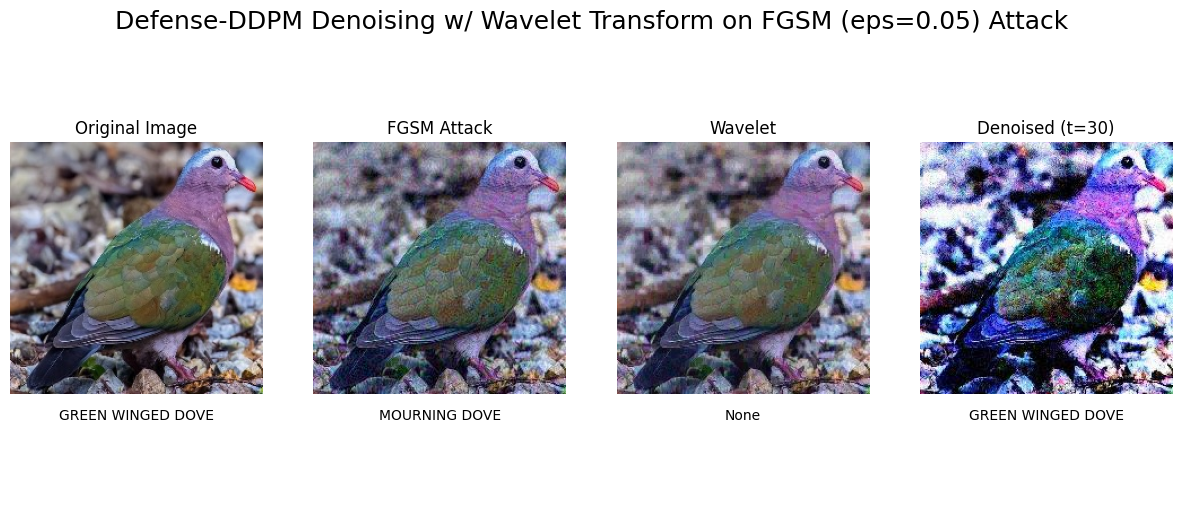

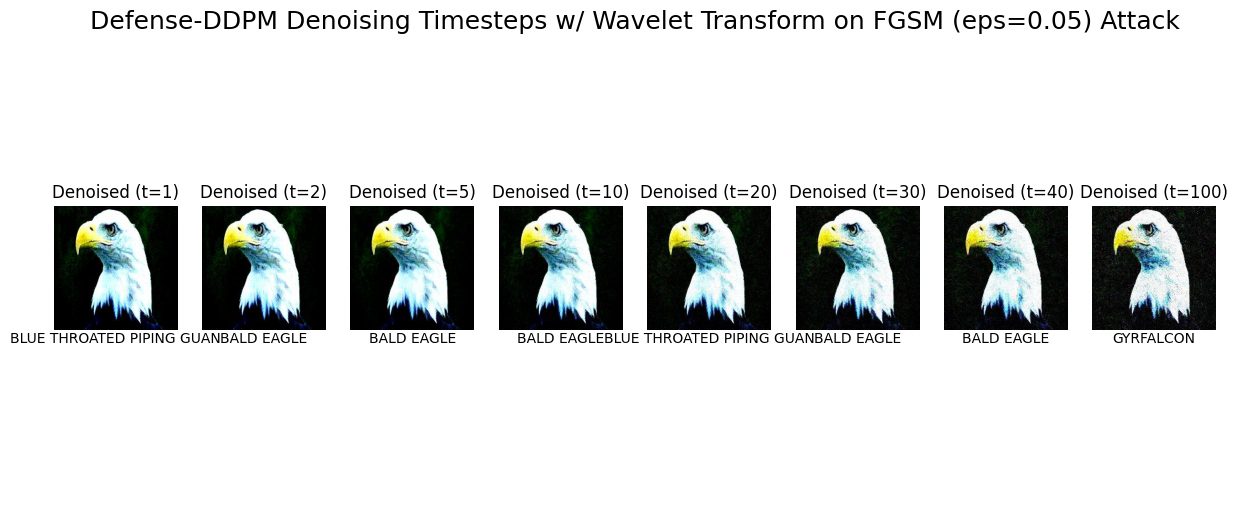

In [40]:
plot_denoising_defense_with_input_transform(fgsm05_def_nofwd_wavelet_eval.succ_denoise[5], "FGSM05-test", "wavelet", "Defense-DDPM Denoising w/ Wavelet Transform on FGSM (eps=0.05) Attack")
plot_each_timestep(fgsm05_def_nofwd_wavelet_df, "FGSM05-test", "wavelet", "Defense-DDPM Denoising Timesteps w/ Wavelet Transform on FGSM (eps=0.05) Attack")

### Defense-DDPM with NL-Means Denoised Input

In [11]:
fgsm05_def_nofwd_nlmeans_df = pd.read_csv("./evaluation_csvs/FGSM05-test-nlmeans-defense-eval.csv")
fgsm05_def_nofwd_nlmeans_eval = DefenseEval("FGSM05 Defense w/ NL-Means Pre-processing (backward_t)", fgsm05_def_nofwd_nlmeans_df)

fgsm05_def_nofwd_nlmeans_eval.evaluate_def()
fgsm05_def_nofwd_nlmeans_eval.print_metrics()

# fid_avg_defenses_nlmeans = fgsm05_def_nofwd_nlmeans_eval.calculate_fid(root="./bird-data/nl-means")
# fgsm05_def_nofwd_nlmeans_eval.store_fid(fid_avg_defenses_nlmeans)
# fgsm05_def_nofwd_nlmeans_eval.print_metrics()

# fgsm05_def_nofwd_nlmeans_eval.succ_defense_df.to_csv("./evaluation_csvs/FGSM05-defense-nlmeans-transform-results.csv")

FGSM05 Defense w/ NL-Means Pre-processing (backward_t)
Successfully Attacked:  74.86%
Successfully Denoised: 
                defense denoise succ.
0    defense_label_t=1         45.65
1    defense_label_t=2         46.26
2    defense_label_t=5         51.20
3   defense_label_t=10         48.45
4   defense_label_t=20         44.33
5   defense_label_t=30         40.76
6   defense_label_t=40         36.49
7  defense_label_t=100         24.94


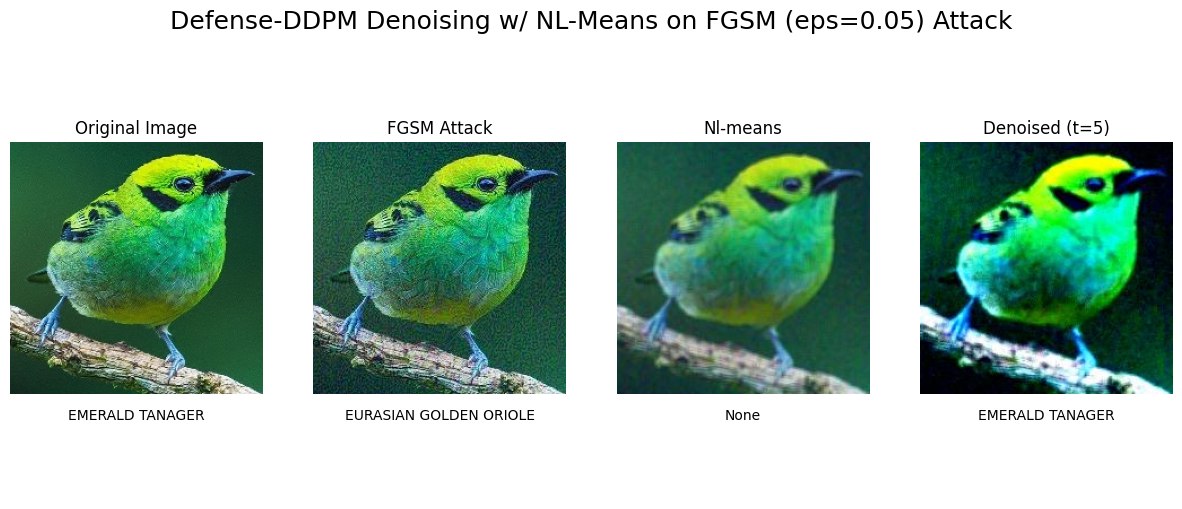

In [18]:
plot_denoising_defense_with_input_transform(fgsm05_def_nofwd_nlmeans_eval.succ_denoise[2], "FGSM05-test", "nl-means", "Defense-DDPM Denoising w/ NL-Means on FGSM (eps=0.05) Attack")

## DDPM Defense Evaluation on FGSM eps=0.25 Attack

DDPM is setup to just do reverse process for `t` timesteps. There is no noise added to forward.

### Defense-DDPM With No Input Transformations

In [ ]:
## TODO

### Defense-DDPM with Wavelet Denoised Input

In [7]:
fgsm25_def_nofwd_wavelet_df = pd.read_csv("./evaluation_csvs/FGSM25-test-wavelet-defense-eval.csv")
fgsm25_def_nofwd_wavelet_eval = DefenseEval("FGSM25 Defense w/ NL-Means Pre-processing (backward_t)", fgsm25_def_nofwd_wavelet_df)

fgsm25_def_nofwd_wavelet_eval.evaluate_def()
fgsm25_def_nofwd_wavelet_eval.print_metrics()

FGSM25 Defense w/ NL-Means Pre-processing (backward_t)
Successfully Attacked:  99.39%
Successfully Denoised: 
                defense denoise succ.
0    defense_label_t=1          4.64
1    defense_label_t=2          5.25
2    defense_label_t=5          6.06
3   defense_label_t=10          6.13
4   defense_label_t=20          6.82
5   defense_label_t=30          7.82
6   defense_label_t=40          7.55
7  defense_label_t=100          7.55


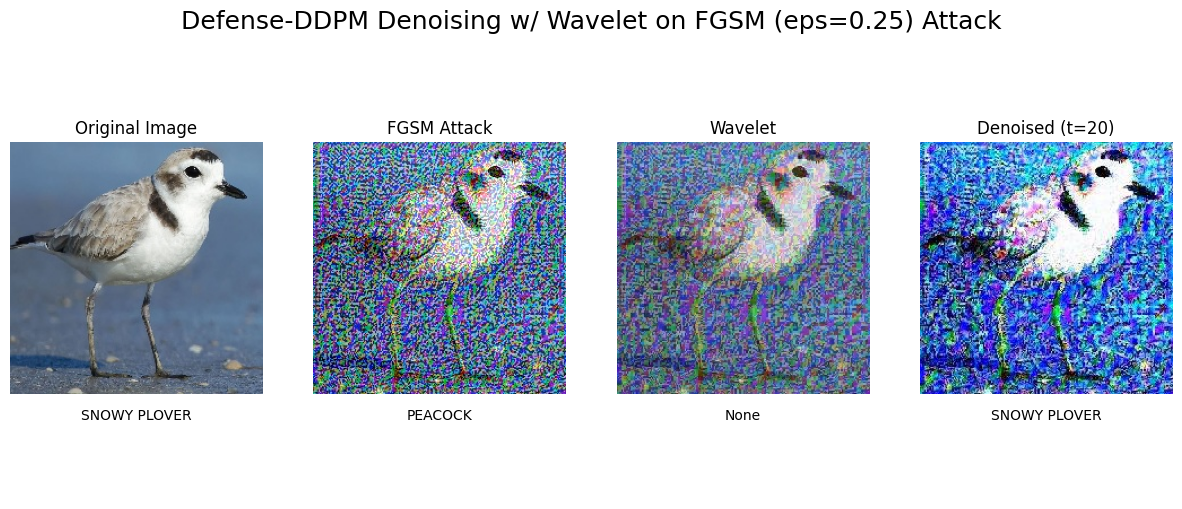

In [9]:
plot_denoising_defense_with_input_transform(fgsm25_def_nofwd_wavelet_eval.succ_denoise[4], "FGSM25-test", "wavelet", "Defense-DDPM Denoising w/ Wavelet on FGSM (eps=0.25) Attack")

### Defense-DDPM with NL-Means Denoised Input

In [5]:
fgsm25_def_nofwd_nlmeans_df = pd.read_csv("./evaluation_csvs/FGSM25-test-nlmeans-defense-eval.csv")
fgsm25_def_nofwd_nlmeans_eval = DefenseEval("FGSM25 Defense w/ NL-Means Pre-processing (backward_t)", fgsm25_def_nofwd_nlmeans_df)

fgsm25_def_nofwd_nlmeans_eval.evaluate_def()
fgsm25_def_nofwd_nlmeans_eval.print_metrics()

# fid_avg_defenses_nlmeans = fgsm25_def_nofwd_nlmeans_eval.calculate_fid(root="./bird-data/nl-means")
# fgsm25_def_nofwd_nlmeans_eval.store_fid(fid_avg_defenses_nlmeans)
# fgsm25_def_nofwd_nlmeans_eval.print_metrics()

# fgsm25_def_nofwd_nlmeans_eval.succ_defense_df.to_csv("./evaluation_csvs/FGSM25-defense-nlmeans-transform-results.csv")

FGSM25 Defense w/ NL-Means Pre-processing (backward_t)
Successfully Attacked:  99.39%
Successfully Denoised: 
                defense denoise succ.
0    defense_label_t=1          7.13
1    defense_label_t=2          7.67
2    defense_label_t=5          8.59
3   defense_label_t=10          8.89
4   defense_label_t=20          9.97
5   defense_label_t=30          9.70
6   defense_label_t=40          9.66
7  defense_label_t=100          9.58


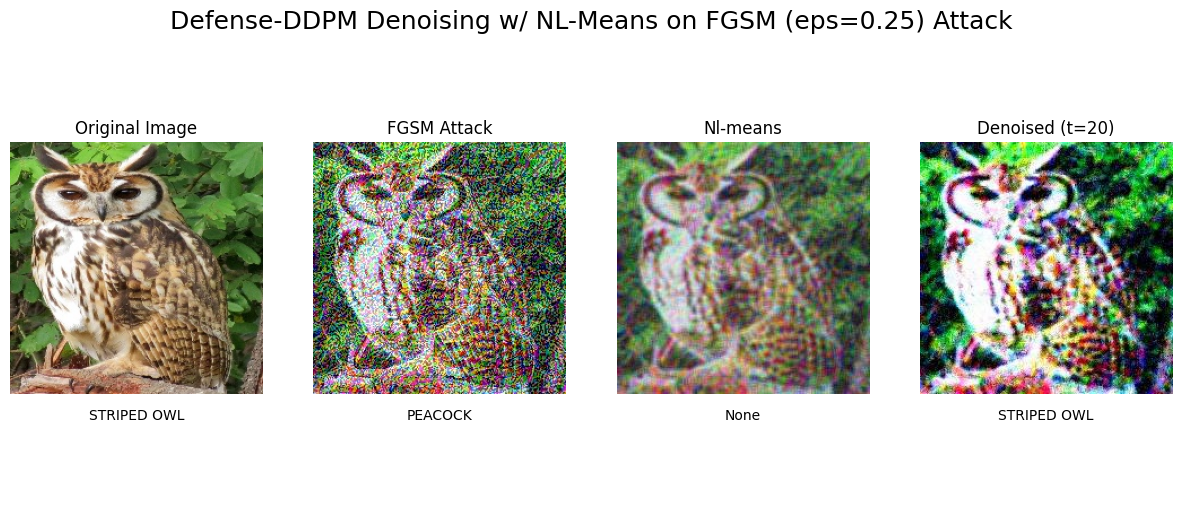

In [63]:
plot_denoising_defense_with_input_transform(fgsm25_def_nofwd_nlmeans_eval.succ_denoise[4], "FGSM25-test", "nl-means", "Defense-DDPM Denoising w/ NL-Means on FGSM (eps=0.25) Attack")

## Generating Clean Image from Adversarial Images

In [196]:
fgsm25_def_df = pd.read_csv("./evaluation_csvs/FGSM25-test-clean-from-adv-eval.csv")
fgsm25_def_eval = DefenseEval("FGSM25 Defense Clean From Adversarial Images", fgsm25_def_df)

fgsm25_def_eval.evaluate_def()
fgsm25_def_eval.print_metrics()

fid_avg_defenses = fgsm25_def_eval.calculate_fid(root="./bird-data")
fgsm25_def_eval.store_fid(fid_avg_defenses)
fgsm25_def_eval.print_metrics()

fgsm25_def_eval.succ_defense_df.to_csv("./evaluation_csvs/FGSM25-defense-clean-from-adv-results.csv")

FGSM25 Defense Clean From Adversarial Images
Successfully Attacked:  99.39%
Successfully Denoised: 
                 defense denoise succ.
0  defense_label_t=1000          0.38
{'defense_label_t=1000': 'FGSM25-test-def-t=1000'}


/tmp/ipykernel_1932451/148605099.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid.update(torch.tensor(true_images, dtype=torch.uint8), real=True)
/tmp/ipykernel_1932451/148605099.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid.update(torch.tensor(def_images, dtype=torch.uint8), real=False)


KeyboardInterrupt: 

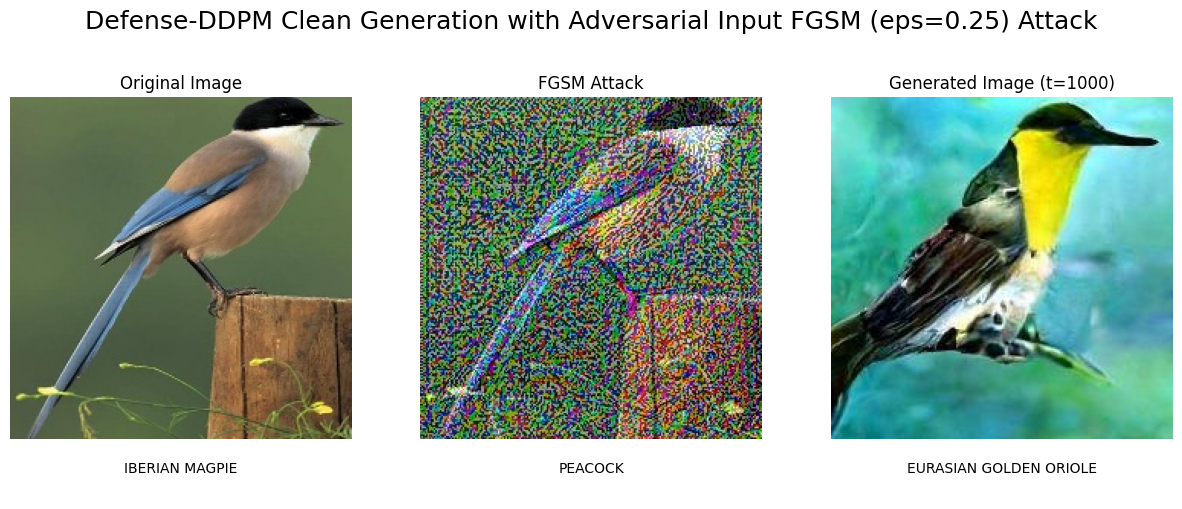

In [191]:
plot_clean_from_adv(fgsm25_def_df, "FGSM25-test", "Defense-DDPM Clean Generation with Adversarial Input FGSM (eps=0.25) Attack")